<a href="https://colab.research.google.com/github/DrDourado/Teaching_ME_615/blob/main/ME_615_03_non_parametric_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook illustrates the concepts of k-nearest neighbor (k-NN) and decision tree classifiers using the sklearn Iris dataset.
The notebook presents the concept of an elbow plot for selecting the optimal number k of neighbors for the k-NN classifier and explores various aspects of decision tree training, including impurity measures like Gini score and entropy, as well as pruning methods like minimum leaf samples and ccp_alphas.

**Objective:** Learn non-parametric classification techniques using k-NN, decision trees, and random forests.

**Topics Covered:**

1. ***k-Nearest Neighbors (k-NN)*** :
* Training k-NN for binary classification.
* Finding the optimal k using an elbow plot.
* Visualizing decision boundaries.
2. ***Decision Trees*** :
* Training and pruning decision trees.
* Visualizing decision boundaries.
3. ***Random Forests*** :
* Understanding majority voting in ensemble methods.
* Training a random forest classifier.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import os

In [2]:
# function to automatically save generated figures (credit to Aurelien Geron "Hands-On Machine Learning with Scikit-Learn & Tensorflow")
ROOT_DIR = "."
IMAGES_PATH = os.path.join(ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Visualize decision boundaries
def plot_decision_boundary(clf, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)

**Loading and Exploring the Dataset**

* The Iris dataset contains features (sepal & petal length/width) for three flower species.
* We convert it into a binary classification problem (Setosa vs. Non-Setosa).

In [4]:
# Load the Iris dataset
iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [5]:
X = iris["data"][:, 2:4]  # petal length and width
y = (iris["target"] == 2).astype(int)  # 1 if Iris virginica, else 0

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**k-Nearest Neighbors (k-NN)**
* k-NN classifies a sample by majority voting among its k nearest neighbors.
* The elbow plot helps identify the best k by analyzing accuracy trends.

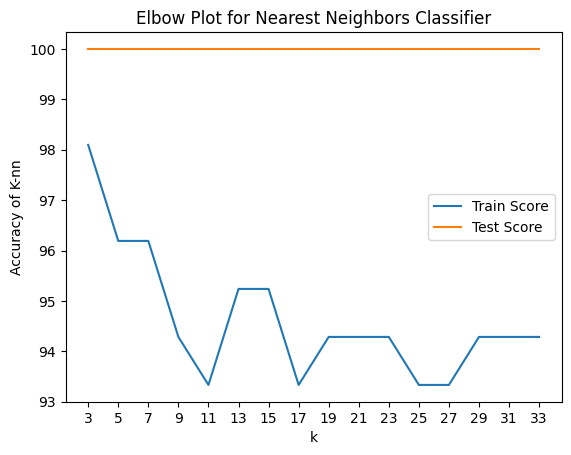

Saving figure knn_elbow_plot


<Figure size 640x480 with 0 Axes>

In [7]:
# Evaluate k values from 3 to 35
neighbors=np.arange(3,35,2)
train_accuracy_knn = np.zeros_like(neighbors,dtype="float")
test_accuracy_knn = np.zeros_like(neighbors,dtype="float")
knn_time = np.zeros_like(neighbors,dtype="float")

for i,neighbors_val in enumerate(neighbors):
    neigh = KNeighborsClassifier(n_neighbors = neighbors_val)
    neigh.fit(X_train_scaled, y_train)
    y_knn_train = neigh.predict(X_train_scaled)
    train_accuracy = (y_train == y_knn_train).sum()/len(y_train)
    train_accuracy_knn[i] = train_accuracy*100
    y_knn_test = neigh.predict(X_test_scaled)
    test_accuracy = (y_test == y_knn_test).sum()/len(y_test)
    test_accuracy_knn[i] = test_accuracy*100

fig = plt.figure()
fig.clf()

plt.plot(neighbors,train_accuracy_knn, label="Train Score")
plt.plot(neighbors,test_accuracy_knn, label="Test Score")
plt.xlabel("k")
plt.ylabel("Accuracy of K-nn")
plt.title("Elbow Plot for Nearest Neighbors Classifier")
plt.xticks(neighbors)
plt.legend()
plt.show()
save_fig("knn_elbow_plot")

In [8]:
# Train k-NN with optimal k (choosing from elbow plot)
optimal_k = neighbors[np.argmin(train_accuracy_knn)]
knn_best = KNeighborsClassifier(n_neighbors=optimal_k)
knn_best.fit(X_train_scaled, y_train)
pred_knn_best = knn_best.predict(X_test_scaled)

print("kNN accuracy: "+str(accuracy_score(y_test, pred_knn_best)*100)+" %")
print("kNN precision: "+str(precision_score(y_test, pred_knn_best)*100)+" %")
print("kNN recall: "+str(recall_score(y_test, pred_knn_best)*100)+" %")
print("kNN f1 score: "+str(f1_score(y_test, pred_knn_best)*100)+" %")
print("kNN confusion matrix: \n"+str(confusion_matrix(y_test, pred_knn_best)))

kNN accuracy: 100.0 %
kNN precision: 100.0 %
kNN recall: 100.0 %
kNN f1 score: 100.0 %
kNN confusion matrix: 
[[32  0]
 [ 0 13]]


Saving figure knn_decision_boundaries


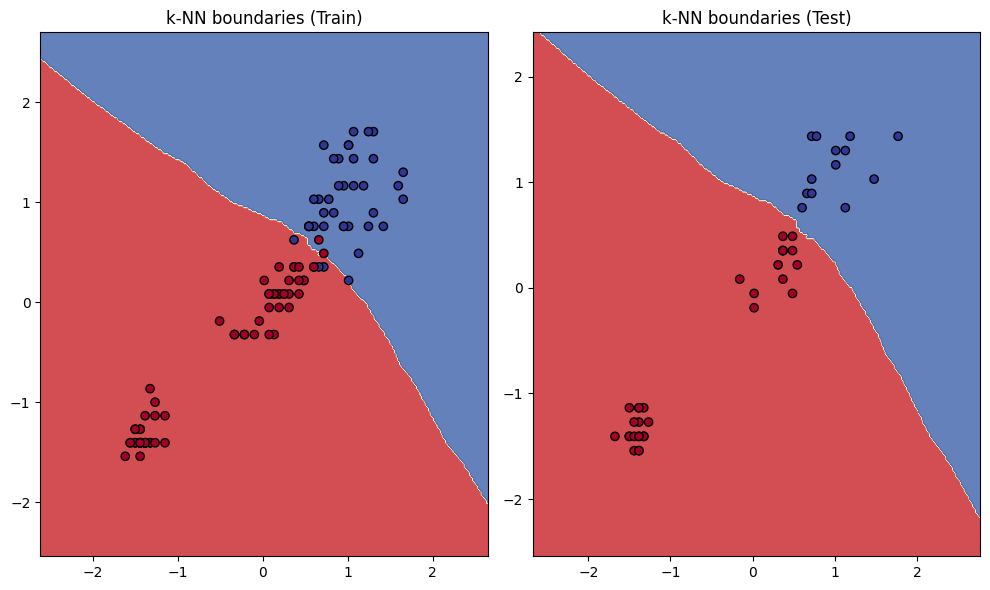

In [9]:
# Plot decision boundaries for different classifiers
plt.figure(figsize=(10, 6))

# Plot decision boundaries for Nearest Neighbors Classifier
plt.subplot(1, 2, 1)
plot_decision_boundary(knn_best, X_train_scaled, y_train, title="k-NN boundaries (Train)")

plt.subplot(1, 2, 2)
plot_decision_boundary(knn_best, X_test_scaled, y_test, title="k-NN boundaries (Test)")
save_fig("knn_decision_boundaries")

**Decision Trees**
* A decision tree splits the data at feature thresholds.
* We prune it by limiting depth to prevent overfitting.
* The decision tree produces a piecewise decision boundary.

Training decision trees revolves around the concept of impurity measure.

The ***Gini impurity*** is a measure used in decision tree algorithms to evaluate how "pure" a node is in terms of classification. It quantifies the likelihood of an incorrect classification of a randomly chosen element if it were randomly labeled according to the distribution of labels in the node. A node with a lower Gini impurity is considered more pure, meaning it predominantly contains instances of a single class.

Mathematically, the Gini impurity of a node \( t \) with \( K \) classes is calculated as follows:
$\text{Gini}(t) = 1 - \sum_{i=1}^{K} p(i|t)^2$

Where:
- \( p(i|t) \) is the probability of randomly selecting an element of class \( i \) from node \( t \).

In a binary classification setting (where \( K = 2 \)), this formula simplifies to:

$\text{Gini}(t) = 1 - p^2 - (1 - p)^2$


The Gini impurity takes values between 0 and 0.5. A value of 0 indicates that the node is pure (i.e., all elements belong to the same class), while a value of 0.5 indicates maximum impurity (i.e., an equal distribution of classes).

In decision tree algorithms, the Gini impurity is used to make decisions about feature splits. When constructing a decision tree, the algorithm searches for the feature and the threshold that minimizes the weighted sum of the Gini impurities of the resulting child nodes. By recursively splitting the data based on features and thresholds, the decision tree aims to create nodes with increasingly pure subsets of data until a stopping criterion is met.


In [10]:
# Decision Tree Classifier
# Train Decision Tree with Gini impurity measure
tree_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
tree_gini.fit(X_train_scaled, y_train)
print("Decision Tree (Gini) - Train Accuracy:", tree_gini.score(X_train_scaled, y_train))
print("Decision Tree (Gini) - Test Accuracy:", tree_gini.score(X_test_scaled, y_test))

Decision Tree (Gini) - Train Accuracy: 0.9904761904761905
Decision Tree (Gini) - Test Accuracy: 1.0


***Entropy*** is another impurity measure commonly used in decision tree algorithms. Similar to the Gini impurity, entropy quantifies the purity of a node in terms of classification. It measures the average uncertainty or randomness in the distribution of class labels within a node.

Mathematically, the entropy of a node \( t \) with \( K \) classes is calculated as follows:

$
\text{Entropy}(t) = - \sum_{i=1}^{K} p(i|t) \log_2(p(i|t))
$

Where:
- \( p(i|t) \) is the probability of randomly selecting an element of class \( i \) from node \( t \).

In a binary classification setting (where \( K = 2 \)), this formula simplifies to:

$
\text{Entropy}(t) = - p \log_2(p) - (1 - p) \log_2(1 - p)
$

The entropy takes values between 0 and 1. A value of 0 indicates that the node is pure (i.e., all elements belong to the same class), while a value of 1 indicates maximum impurity (i.e., an equal distribution of classes).

In decision tree algorithms, entropy is used similarly to the Gini impurity. The algorithm searches for the feature and the threshold that minimizes the weighted sum of the entropies of the resulting child nodes. By recursively splitting the data based on features and thresholds, the decision tree aims to create nodes with increasingly pure subsets of data until a stopping criterion is met.

In [11]:
# Train Decision Tree with Entropy impurity measure
tree_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree_entropy.fit(X_train_scaled, y_train)
print("Decision Tree (Entropy) - Train Accuracy:", tree_entropy.score(X_train_scaled, y_train))
print("Decision Tree (Entropy) - Test Accuracy:", tree_entropy.score(X_test_scaled, y_test))

Decision Tree (Entropy) - Train Accuracy: 0.9904761904761905
Decision Tree (Entropy) - Test Accuracy: 1.0


***Pruning methods*** :

In [12]:
# Minimum samples in leaf
tree_min_samples = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_min_samples.fit(X_train_scaled, y_train)
print("Decision Tree (Min Samples in Leaf) - Train Accuracy:", tree_min_samples.score(X_train_scaled, y_train))
print("Decision Tree (Min Samples in Leaf) - Test Accuracy:", tree_min_samples.score(X_test_scaled, y_test))

Decision Tree (Min Samples in Leaf) - Train Accuracy: 0.9428571428571428
Decision Tree (Min Samples in Leaf) - Test Accuracy: 1.0


***Cost-complexity pruning (ccp)*** is a technique used to reduce the complexity of decision trees by trimming off parts of the tree that contribute little to the overall predictive accuracy. It adds a penalty term to the impurity measure (such as Gini impurity or entropy) to penalize the complexity of the tree. The penalty is controlled by a hyperparameter called alpha (ccp_alpha).

Here's how cost-complexity pruning works:

1. Train a decision tree on the training data.
2. Calculate the impurity (e.g., Gini impurity or entropy) of each node in the tree.
3. Calculate the total impurity of the tree by summing the impurities of all nodes.
4. Introduce a penalty term based on the number of nodes in the tree (tree complexity).
5. Adjust the penalty term using the hyperparameter alpha (ccp_alpha).
6. Select the subtree that minimizes the cost-complexity criterion (total impurity + penalty).
7. Repeat steps 4-6 for different values of alpha to create a sequence of subtrees.
8. Choose the optimal subtree based on cross-validation or another criterion.

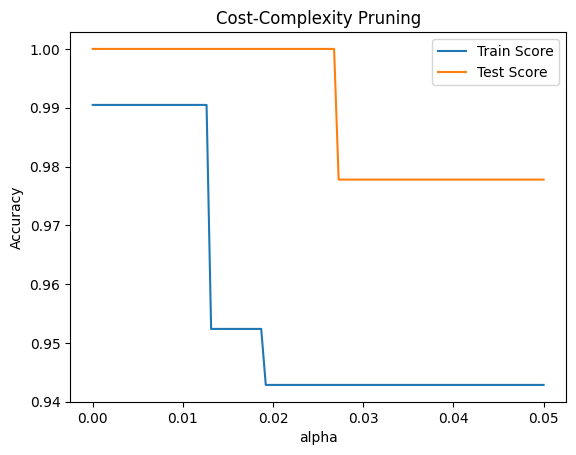

Saving figure cost_complexity_pruning


<Figure size 640x480 with 0 Axes>

In [13]:
# Cost-Complexity Pruning (CCP)
ccp_alphas = np.linspace(0, 0.05, 100)
trees_ccp = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=42)
    tree.fit(X_train, y_train)
    trees_ccp.append(tree)

train_scores_ccp = [tree.score(X_train, y_train) for tree in trees_ccp]
test_scores_ccp = [tree.score(X_test, y_test) for tree in trees_ccp]

fig = plt.figure()
fig.clf()

plt.plot(ccp_alphas,train_scores_ccp, label="Train Score")
plt.plot(ccp_alphas,test_scores_ccp, label="Test Score")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Cost-Complexity Pruning")
plt.legend()
plt.show()
save_fig("cost_complexity_pruning")

In [14]:
best_ccp_index = np.argmin(test_scores_ccp)
best_ccp_alpha = ccp_alphas[best_ccp_index]
best_tree_ccp = trees_ccp[best_ccp_index]

print("Decision Tree (CCP) - Best Alpha:", best_ccp_alpha)
print("Decision Tree (CCP) - Train Accuracy:", best_tree_ccp.score(X_train, y_train))
print("Decision Tree (CCP) - Test Accuracy:", best_tree_ccp.score(X_test, y_test))

Decision Tree (CCP) - Best Alpha: 0.02727272727272727
Decision Tree (CCP) - Train Accuracy: 0.9428571428571428
Decision Tree (CCP) - Test Accuracy: 0.9777777777777777


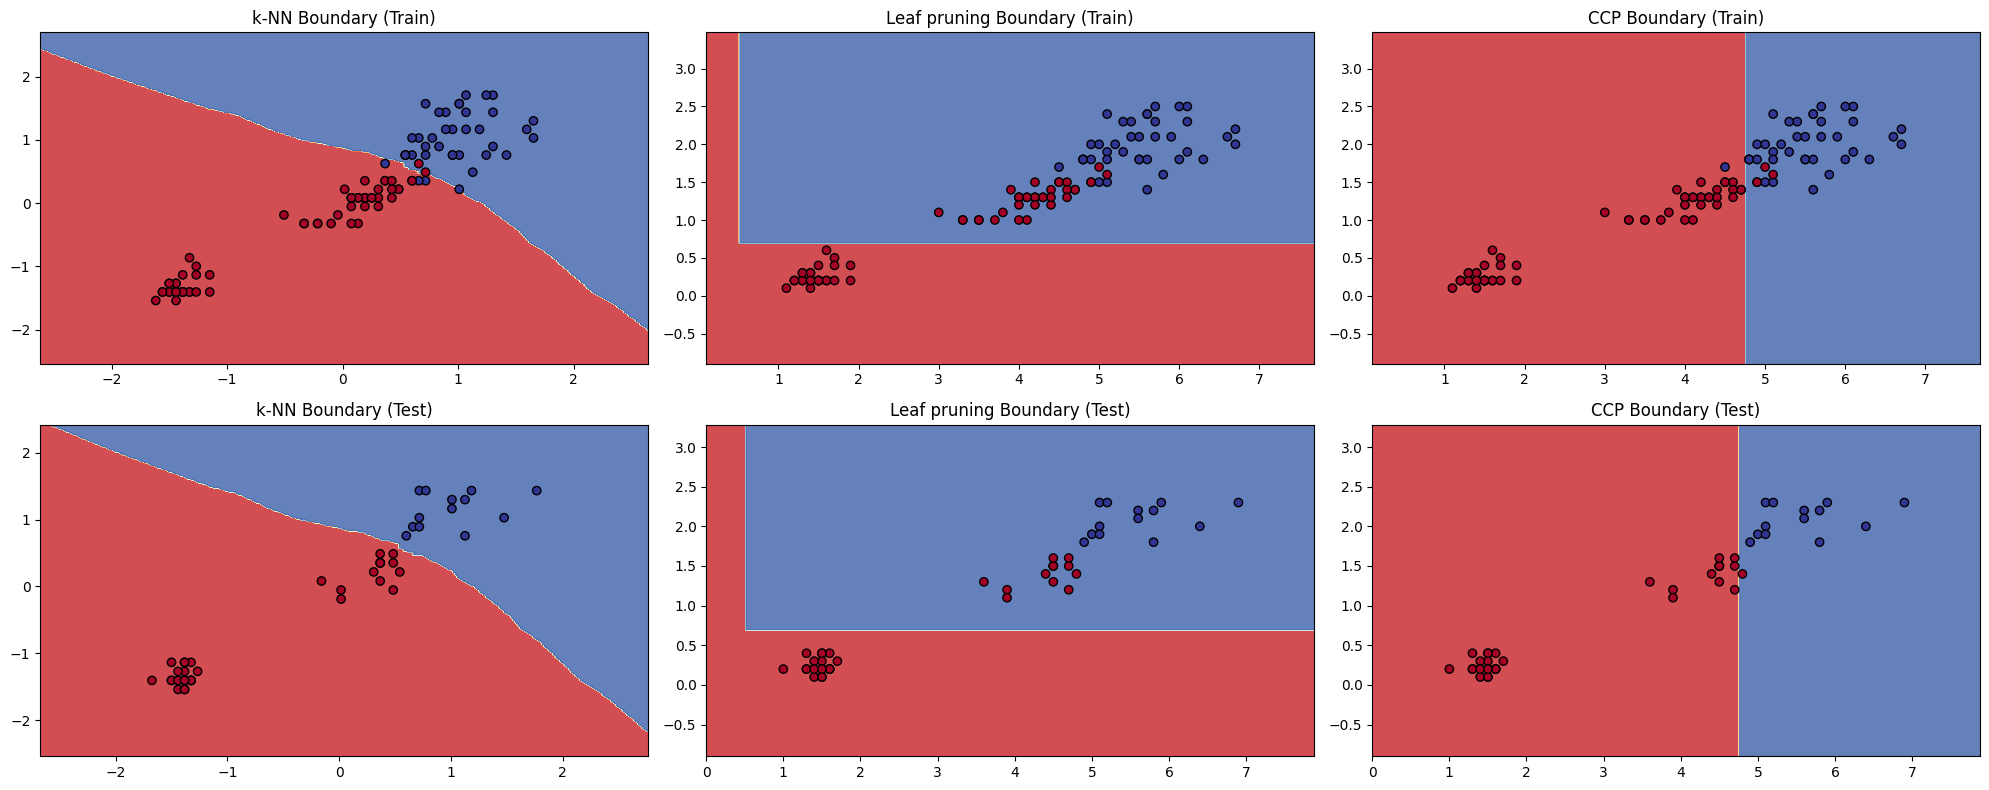

Saving figure decision_tree_boundaries


<Figure size 640x480 with 0 Axes>

In [15]:
# Plot decision boundaries for different classifiers
plt.figure(figsize=(20, 8))

# Plot decision boundaries for Nearest Neighbors Classifier
plt.subplot(2, 3, 1)
plot_decision_boundary(knn_best, X_train_scaled, y_train, title="k-NN Boundary (Train)")

plt.subplot(2, 3, 4)
plot_decision_boundary(knn_best, X_test_scaled, y_test, title="k-NN Boundary (Test)")

# Plot decision boundaries for Decision Tree (Gini)
plt.subplot(2, 3, 2)
plot_decision_boundary(tree_min_samples, X_train, y_train, title="Leaf pruning Boundary (Train)")

plt.subplot(2, 3, 5)
plot_decision_boundary(tree_min_samples, X_test, y_test, title="Leaf pruning Boundary (Test)")

# Plot decision boundaries for Decision Tree (Entropy)
plt.subplot(2, 3, 3)
plot_decision_boundary(best_tree_ccp, X_train, y_train, title="CCP Boundary (Train)")

plt.subplot(2, 3, 6)
plot_decision_boundary(best_tree_ccp, X_test, y_test, title="CCP Boundary (Test)")

plt.tight_layout()
plt.show()
save_fig("decision_tree_boundaries")

***Random Forests (Ensemble Learning)***
* Random forests train multiple decision trees and use majority voting.


In [16]:
# Train a random forest with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluate accuracy
y_pred_rf = rf.predict(X_test_scaled)

In [17]:
print("Random Forest accuracy: "+str(accuracy_score(y_test, y_pred_rf)*100)+" %")
print("Random Forest precision: "+str(precision_score(y_test, y_pred_rf)*100)+" %")
print("Random Forest recall: "+str(recall_score(y_test, y_pred_rf)*100)+" %")
print("Random Forest f1 score: "+str(f1_score(y_test, y_pred_rf)*100)+" %")
print("Random Forest confusion matrix: \n"+str(confusion_matrix(y_test, y_pred_rf)))

Random Forest accuracy: 100.0 %
Random Forest precision: 100.0 %
Random Forest recall: 100.0 %
Random Forest f1 score: 100.0 %
Random Forest confusion matrix: 
[[32  0]
 [ 0 13]]


Saving figure rf_decision_boundaries


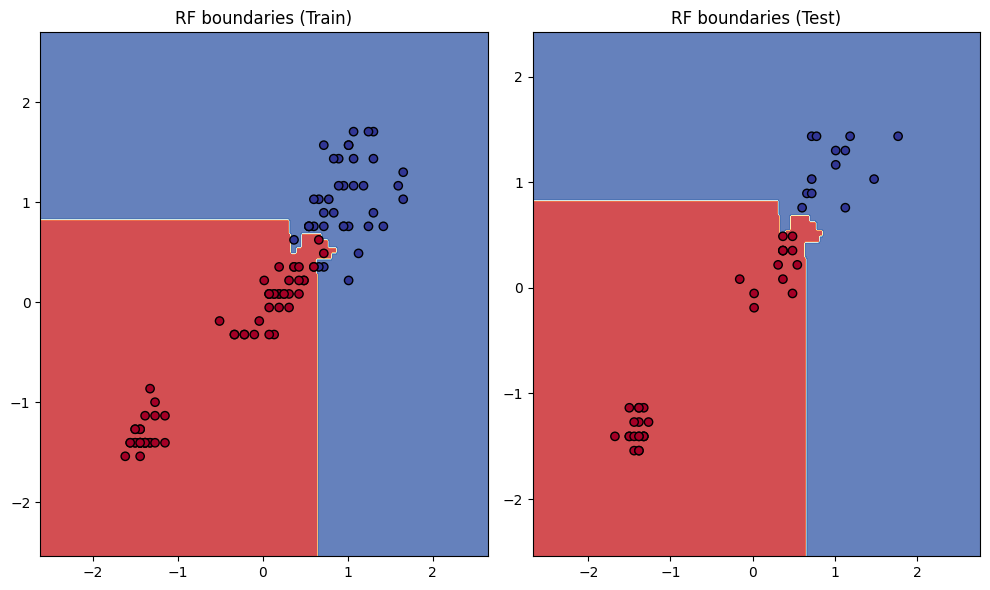

In [19]:
plt.figure(figsize=(10, 6))

# Plot decision boundaries for Random Forest Classifier
plt.subplot(1, 2, 1)
plot_decision_boundary(rf, X_train_scaled, y_train, title="RF boundaries (Train)")

plt.subplot(1, 2, 2)
plot_decision_boundary(rf, X_test_scaled, y_test, title="RF boundaries (Test)")
save_fig("rf_decision_boundaries")